# Random Sampling

In this notebook we work with the obstacle's polygon representation itself.

We can leverage a powerful Python package called [Shapely](http://shapely.readthedocs.io/en/stable/manual.html). 

The tasks will be:

1. Create polygons.
2. Sample random 3D points.
3. Remove points contained by an obstacle polygon.

Recall, a point $(x, y, z)$ collides with a polygon if the $(x, y)$ coordinates are contained by the polygon and the $z$ coordinate (height) is less than the height of the polygon.

In [13]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from shapely.geometry import Polygon, Point

from grid import create_grid

%matplotlib inline 

plt.rcParams['figure.figsize'] = 13, 13

In [2]:
# Obstacle data
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print('Data shape:', data.shape)
print('\n',data)

Data shape: (3845, 6)

 [[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


### Create Polygons

In [3]:
def extract_polygons(data):
    polygons = []
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]
        
        # Extract the 4 corners of the obstacle
        # NOTE: The order of the points matters since `shapely` draws
        # the sequentially counterclockwise from point to point.
        #
        # If the area of the polygon is 0 you've likely got a weird order.
        p1 = (north + d_north, east - d_east)
        p2 = (north + d_north, east + d_east)
        p3 = (north - d_north, east + d_east)
        p4 = (north - d_north, east - d_east)
        corners = [p1, p2, p3, p4]
        
        # Compute the height of the polygon
        height = alt + d_alt

        # Define polygons, adding height as attribute of each
        p = Polygon(corners)
        polygons.append((p, height))

    return polygons

In [4]:
polygons = extract_polygons(data)
print('Number of polygons created:', len(polygons))

print('Area of a selected polygon:',polygons[3844][0].area)

Number of polygons created: 3845
Area of a selected polygon: 4.441741711935839


### Sampling 3D Points

Let's sample random 3D points in the max and min values for each dimension.

The uniform distribution makes sense in this situation since we we'd like to encourage searching the whole space.

In [5]:
# X limits
xmin = np.min(data[:, 0] - data[:, 3])
xmax = np.max(data[:, 0] + data[:, 3])

# Y limits
ymin = np.min(data[:, 1] - data[:, 4])
ymax = np.max(data[:, 1] + data[:, 4])

# Z limits
zmin = 0
zmax = 5    # Limit the z axis for the visualization

print("X")
print("min = {0}, max = {1}\n".format(xmin, xmax))

print("Y")
print("min = {0}, max = {1}\n".format(ymin, ymax))

print("Z")
print("min = {0}, max = {1}".format(zmin, zmax))

X
min = -315.2389, max = 604.7611

Y
min = -444.2315, max = 475.7685

Z
min = 0, max = 5


In [6]:
# Number of samples
num_samples = 200

# Sampling points
xvals = np.random.uniform(xmin, xmax, num_samples)
yvals = np.random.uniform(ymin, ymax, num_samples)
zvals = np.random.uniform(zmin, zmax, num_samples)

samples = list(zip(xvals, yvals, zvals))

In [7]:
# Print the first 10 sampled points
samples[:10]

[(240.0278250307088, 80.70691915418661, 2.5844969192382643),
 (597.0820560277011, -167.21316667505994, 1.505303061981647),
 (175.0260927882744, 51.54532516931772, 2.371278819291499),
 (576.2367016622695, 369.503629331272, 0.5448894691571232),
 (-301.5767109562404, 69.10555186928525, 3.179783527941702),
 (-159.24911043133963, -231.20546983391375, 1.5023576881743734),
 (-113.59007001836383, 46.74052535964921, 1.9797921217430225),
 (61.67003297316052, 466.62098006430665, 2.5067538442391673),
 (50.171408333154375, 379.4940774202804, 3.9761840121302643),
 (287.4847199740306, -40.79507147551902, 4.656987899016395)]

### Removing Points Colliding With Obstacles

Prior to remove a point we must determine whether it collides with any obstacle. This is done by the `collides` function below. It returns `True` if the point collides with *any* obstacle and `False` if no collision is detected.

In [10]:
def collides(polygons, point):   
    ''' This function Determine whether the point collides 
    with any obstacles.
    '''
    for (poly, height) in polygons:
        if poly.contains(Point(point)) and height > point[2]:
            return True
    return False

In [11]:
# Removal of all the sampled points that collides
t0 = time.time()
to_keep = []

for point in samples:
    if not collides(polygons, point):
        to_keep.append(point)
        
time_taken = time.time() - t0
print('Time taken {:0.2f} seconds ...'.format(time_taken))
print('{} sampled points collide. They are removed from the list!'.format(num_samples - len(to_keep)))

Time taken 11.78 seconds ...
72 sampled points collide. They are removed from the list!


### Points Visualization

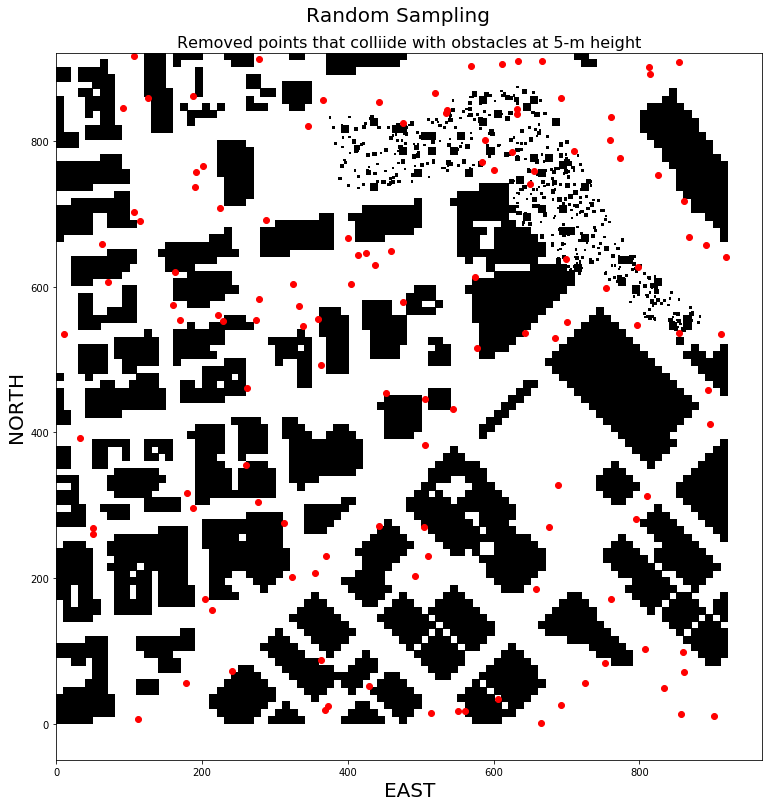

In [14]:
# Grid creation
grid = create_grid(data, zmax, 0)

# minimum north and east coordinates
north_min = np.floor(np.min(data[:, 0] - data[:, 3]))
east_min = np.floor(np.min(data[:, 1] - data[:, 4]))

# Plotting
fig = plt.figure()
plt.imshow(grid, cmap='Greys', origin='lower')

# draw points
all_pts = np.array(to_keep)
north_vals = all_pts[:,0]
east_vals = all_pts[:,1]
plt.scatter(east_vals - east_min, north_vals - north_min, marker='o', color='red')

plt.xlabel('EAST', fontsize=20)
plt.ylabel('NORTH', fontsize=20)
plt.suptitle('Random Sampling', fontsize=20, x=0.5, y=0.93)
plt.title('Removed points that colliide with obstacles at {}-m height'.format(zmax),
          fontsize=16, x=0.5, y=1.0)

plt.show()

## Epilogue

You may have noticed removing points can be quite lengthy. In the implementation provided here we're naively checking to see if the point collides with each polygon when in reality it can only collide with one, the one that's closest to the point. The question then becomes "How do we efficiently find the closest polygon to the point?"

One such approach is to use a *[k-d tree](https://en.wikipedia.org/wiki/K-d_tree)*, a space-partitioning data structure which allows search queries in $O(log(n))$. The *k-d tree* achieves this by cutting the search space in half on each step of a query.

This would bring the total algorithm time down to $O(m * log(n))$ from $O(m*n)$.

The scikit-learn library has an efficient implementation [readily available](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree).